In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm

In [2]:
np.random.seed(1)

In [3]:
df = pd.read_csv("SPY.csv", parse_dates=True, index_col="Date")

In [4]:
returns = np.log(df["Close"]).diff()

In [5]:
returns.dropna(inplace=True)

In [6]:
returns

Date
2010-01-05    0.002644
2010-01-06    0.000704
2010-01-07    0.004212
2010-01-08    0.003322
2010-01-11    0.001396
                ...   
2018-12-21   -0.026525
2018-12-24   -0.026778
2018-12-26    0.049290
2018-12-27    0.007648
2018-12-28   -0.001291
Name: Close, Length: 2262, dtype: float64

<Axes: >

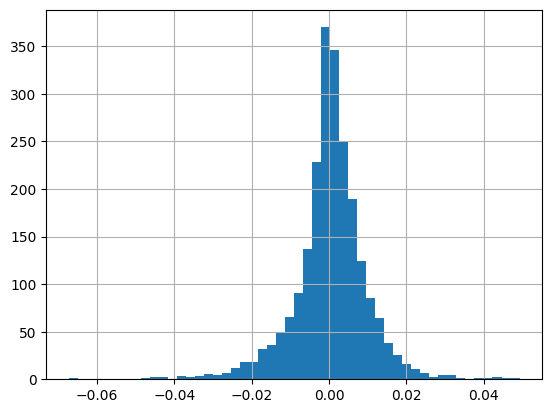

In [7]:
# ricordiamo che abbiamo una fat-tailed distribution
# Una fat-tailed distribution (t-distribution) è simile alla gaussiana, ma è più alta e "snella". I valori estremi, tuttavia, sono più importanti
returns.hist(bins=50)

#### Spiegazione sul modello creato

Consideriamo già il fatto che stiamo scegliendo di rappresentare tutto con due gaussiane. Questo per rimanere nell'idea di modellare high e low volatility nei returns.

Il parametro veramente particolare è la covariance type. Quando analizziamo delle distribuzioni multivariate, anche la gaussiana che la compone è multivariata. Questo significa che la sua media è un vettore di medie e la sua varianza non è un numero, ma è una matrice di covarianza. Una gaussiana monovariata, invece, ha un numero per la media ed un numero per la varianza. E in ciò, niente di nuovo.

Se però vediamo le formule per la PDF della gaussiana, possiamo vedere tranquillamente che al suo interno ci sono le formule per l'inversa e il determinante della matrice di covarianza. Può succedere, in alcuni scenari, che i nostri punti possano essere clusterizzati tutti in maniera "stretta", portando ad una matrice di covarianza "Singolare" (l'equivalente di avere una varianza pari a 0). Questo non permetterebbe l'inversione della matrice, come nel caso monovariato la divisione per 0 crea instabilità numerica.

Con una matrice di covarianza diagonale, noi otteniamo che i valori non diagonali diventano 0, a vantaggio di quelli diagonali. Inoltre, diagonalizzando la matrice, sarà più facile sia calcolare la matrice inversa che il determinante. In realtà esisterebbe la pseudoinversa, in caso, che permetterebbe di mitigare questo problema.

Nel nostro caso non cambia niente, in realtà. La nostra gaussiana è monovariata.

In [8]:
# Scegliamo che abbiamo
model = hmm.GaussianHMM(n_components=2, covariance_type="diag")

In [9]:
X = returns.to_numpy().reshape(-1, 1)
model.fit(X)

GaussianHMM(n_components=2)

In [10]:
Z = model.predict(X)

In [11]:
# La nostra sequenza di stati.
# Abbiamo dei cluster, qui, che sono i nostri "stati" rappresentati come gaussiane. Ancora non sappiamo cosa significhino
Z

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

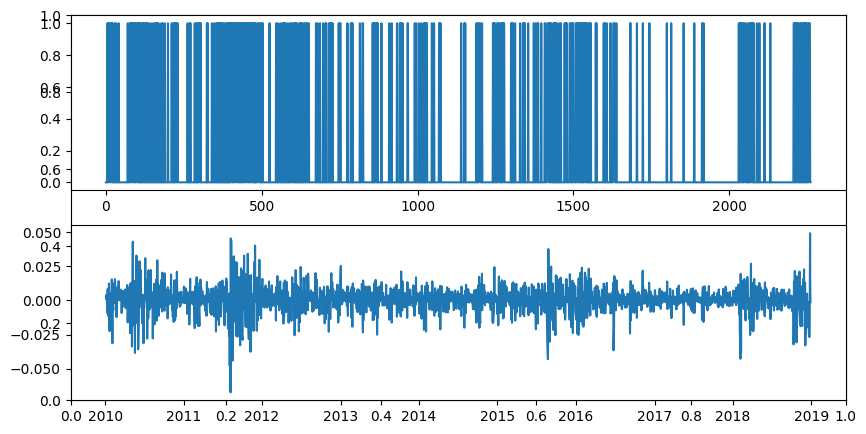

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.subplot(211)
plt.plot(Z)
plt.subplot(212)
plt.plot(returns)

####  Considerazioni sul plot

Notiamo un comportamento alquanto instabile per quanto riguarda i regimi. Dall'uso dei colori è possibile notare, effettivamente, che lo stato 1 intuitivamente rappresenta l'alta varianza, lo stato 0 rappresenta la bassa varianza. Tuttavia, in alcuni tratti, il regime di alta varianza sembra essere effimero. 
E' un comportamento che ci aspettiamo? Potrebbe, però un regime non dura solo un giorno. Noi sappiamo che esiste il concetto di volatility clustering, quindi cerchiamo un attimo di sistemare

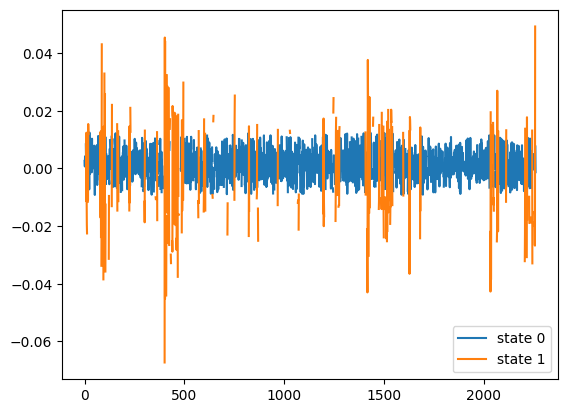

In [13]:
# Usiamo i colori diversi per ogni stato sul plot dei returns
# Iniziamo con degli array nulli

returns0 = np.empty(len(Z))
returns1 = np.empty(len(Z))
returns0[:] = np.nan
returns1[:] = np.nan

# Ora usiamo la ricerca condizionale negli array per popolare correttamente
returns0[Z == 0] = returns[Z == 0]
returns1[Z == 1] = returns[Z == 1]

plt.plot(returns0, label='state 0')
plt.plot(returns1, label='state 1')
plt.legend();

In [14]:
# Diamo uno sguardo alla matrice A di transizione
model.transmat_

array([[0.59165383, 0.40834617],
       [0.5664014 , 0.4335986 ]])

In [16]:
# Proviamo a settare la nostra matrice in maniera manuale, seguendo l'intuizione
# Questo è un approccio sbagliato, ma vediamo se funziona
model.transmat_ = np.array([
    [0.999, 0.001],
    [0.001, 0.999]
])

In [17]:
Z = model.predict(X)

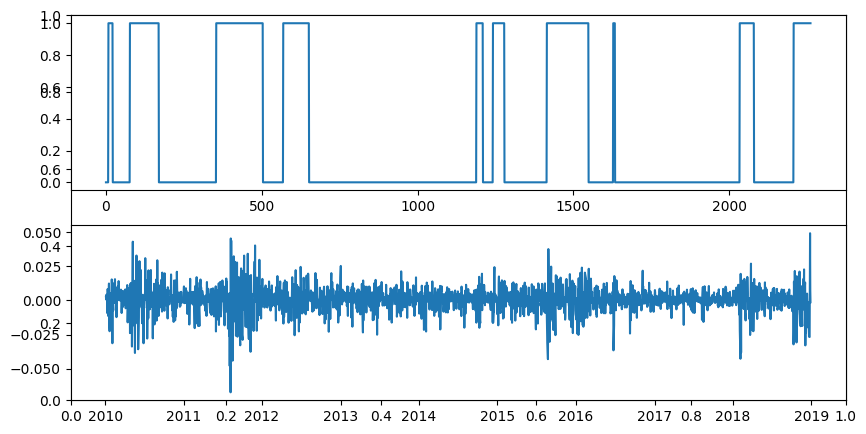

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.subplot(211)
plt.plot(Z)
plt.subplot(212)
plt.plot(returns)

#### Considerazioni:

Abbiamo forzato effettivamente la mano: abbiamo reso le probabilità di switch di stato quasi nulle, il che ha creato delle zone di regime. Rimangono ancora apprese le medie e le varianze delle due gaussiane

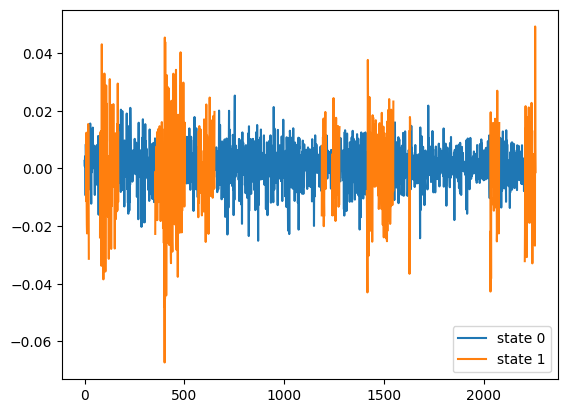

In [19]:
returns0 = np.empty(len(Z))
returns1 = np.empty(len(Z))
returns0[:] = np.nan
returns1[:] = np.nan

returns0[Z == 0] = returns[Z == 0]
returns1[Z == 1] = returns[Z == 1]

plt.plot(returns0, label='state 0')
plt.plot(returns1, label='state 1')
plt.legend();